In [ ]:
import os
import subprocess

# Path to the Darknet executable and obj.data file
darknet_path = './darknet'
obj_data_file = 'obj.data'
cfg_file = 'yolo_608.cfg'
threshold = '0.05'
output_dir = 'ensemble1/'

# Define your model ranges
models = {
    'model_1': range(1, 10),
    'model_2': range(1, 8),
    'model_3': range(1, 10),
    'model_4': range(1, 8)
}

# Path to the test.txt file
test_file = 'test.txt'

# Read image paths from the test.txt
with open(test_file, 'r') as f:
    image_paths = f.read().splitlines()

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through each image path and each model
for image_path in image_paths:
    for model_prefix, model_range in models.items():
        for x in model_range:
            model_name = f'backup/{model_prefix}_{x}.weights'
            output_json = f'{output_dir}/{model_prefix}_{x}.json'

            # Run the Darknet detector command
            command = [
                darknet_path,
                'detector', 'test', obj_data_file,
                cfg_file, model_name,
                '-thresh', threshold, '-dont_show',
                image_path,
                '-out', output_json
            ]

            # Run the command
            subprocess.run(command)

print("Inference completed for all models and images!")


In [100]:
import numpy as np
from PIL import Image
import json
import os
import time
from glob import glob


Classes = ["D00","D10","D20","D40"]
# Names = ["Czech","India","Japan"] #no names should be given
# Box = [600,720,600] #boxes should be automatically caluated

In [101]:
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [102]:
# with open('ensemble2/base_model.json', 'r') as f:
#     D = json.load(f)


Ensemble_D = {}


mods = glob('ensemble1/model_*')

for mod_idx in range(len(mods)):
    with open(mods[mod_idx], 'r') as f:
        Ensemble_D[mod_idx] = json.load(f)

In [103]:
# !rm "ensemble1.txt"
# con = 0.08
con = 0.121
# con4 = 0.4
nm = 1


submission = list()
dets = list()

for count in range(len(D)):
    line = list()
    boxes = list()
    # Extract the full path
    full_path = '/home/opryan90/IEEE-Big-Data-2020/image.png'
    line.append(full_path)
    # Extract the filename from the path
    name = full_path.split("/")[-1]
    line.append(name)
    # Example usage of the full path
    image_path = full_path  # This is the actual image path
    image = Image.open(image_path)
    width, height = image.size  # Get image dimensions
    # if (len(D[count]['objects']))!=0:
    #     for bound in (D[count]['objects']):
    #         if bound['confidence'] >=con:
    #             idx = Classes.index(bound['name']) + 1
    #             # Now, use width and height to calculate the bounding box coordinates
    #             y = bound['relative_coordinates']['center_y'] * height
    #             x = bound['relative_coordinates']['center_x'] * width
    #             h = bound['relative_coordinates']['height'] * height * 0.5
    #             w = bound['relative_coordinates']['width'] * width * 0.5

    #             # Append box coordinates (left, top, right, bottom)
    #             boxes.append([int(x - w), int(y - h), int(x + w), int(y + h), bound['confidence'], idx])

    
    for mod_idx in range(len(mods)):
        if (len(Ensemble_D[mod_idx][count]['objects']))!=0:
            for bound in (Ensemble_D[mod_idx][count]['objects']):
                if bound['confidence'] >=con:
                    idx = Classes.index(bound['name']) + 1
                    # Now, use width and height to calculate the bounding box coordinates
                    y = bound['relative_coordinates']['center_y'] * height
                    x = bound['relative_coordinates']['center_x'] * width
                    h = bound['relative_coordinates']['height'] * height * 0.5
                    w = bound['relative_coordinates']['width'] * width * 0.5

                    # Append box coordinates (left, top, right, bottom)
                    boxes.append([int(x - w), int(y - h), int(x + w), int(y + h), bound['confidence'], idx])
    
    
    if len(boxes) > 0:
        boxes = np.array(boxes).reshape(-1,6)            
        ore = nms(boxes,nm)
        
        for o in ore:
            line.extend([boxes[o,5],boxes[o,0],boxes[o,1],boxes[o,2],boxes[o,3]])
            

    with open("ensemble2.txt", "a") as text_file:
        for a in line[0:1]:
            text_file.write(str(a) + ",")
        dets.extend(line[1:])

        for a in line[1:]:
            try:
                text_file.write('%d' % int(a))  # Convert to integer if possible
            except ValueError:
                text_file.write('%s' % str(a))  # Fallback to string if conversion fails
            text_file.write(' ')

        text_file.write("\n")

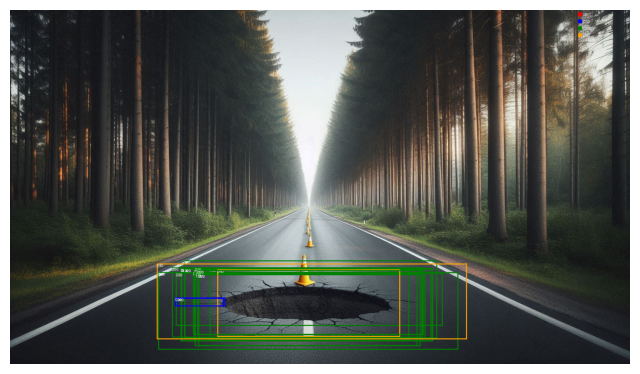

In [105]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Path to your image
image_path = "/home/opryan90/IEEE-Big-Data-2020/image.png"
image = Image.open(image_path)

# Bounding box data from the output
output_data = "image.png, 3 468 745 1192 947 3 531 752 1191 957 3 531 752 1191 957 3 495 747 1221 957 3 495 747 1221 957 3 495 747 1221 957 3 428 759 1295 982 3 428 759 1295 982 3 428 759 1295 982 3 493 748 1222 958 3 493 748 1222 958 3 493 748 1222 958 3 493 748 1222 958 3 493 748 1222 958 3 493 748 1222 958 3 577 751 1153 956 3 577 751 1153 956 3 504 749 1217 949 3 504 749 1217 949 3 544 765 1177 971 3 544 765 1177 971 3 544 765 1177 971 3 534 764 1186 972 3 534 764 1186 972 3 479 761 1250 913 3 479 761 1250 913 3 503 725 1234 949 3 529 758 1194 939 3 534 746 1200 949 4 599 751 1127 945 3 541 753 1195 940 3 541 753 1195 940 2 477 832 622 857 2 477 832 622 857 2 483 833 617 857 2 483 833 617 857 4 424 734 1320 952 "
data = output_data.split(",")[1].strip().split()

# Group the bounding boxes (since the format repeats every 5 items: class, x_min, y_min, x_max, y_max)
bounding_boxes = [data[i:i + 5] for i in range(0, len(data), 5)]

# Class labels and corresponding colors
classes = ["D0", "D10", "D20", "D40"]
colors = ["red", "blue", "green", "orange"]  # Different color for each class

# Create a drawing context
draw = ImageDraw.Draw(image)

# Loop through the bounding boxes and draw them
for box in bounding_boxes:
    class_id, x_min, y_min, x_max, y_max = map(int, box)
    class_label = classes[class_id - 1]  # Map class ID to the corresponding label
    color = colors[class_id - 1]  # Use the color associated with the class
    draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=3)
    draw.text((x_min, y_min), f"{class_label}", fill="white")

# Add a key/legend in the top-right corner
key_start_x = image.width - 150
key_start_y = 10
key_spacing = 20

for i, class_label in enumerate(classes):
    draw.rectangle([key_start_x, key_start_y + i * key_spacing, key_start_x + 10, key_start_y + 10 + i * key_spacing], fill=colors[i])
    draw.text((key_start_x + 15, key_start_y + i * key_spacing), class_label, fill="white")

# Display the image with bounding boxes using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.show()

# Optionally, save the result
output_image_path = "/home/opryan90/IEEE-Big-Data-2020/image_with_boxes_and_key.png"
image.save(output_image_path)
